In [376]:
import pyspark
from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import sparknlp
import nltk
from sparknlp.base import *
from sparknlp.annotator import *
from nltk.corpus import stopwords
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
import time
from matplotlib import pyplot as plt

In [323]:
#!pyspark --version
#sparknlp.start()

In [324]:
#!spark-shell --version

In [325]:
#!pip install pyspark==3.1.1

In [326]:
#!pip install spark-nlp

In [327]:
my_spark = SparkSession \
    .builder \
    .appName("NLPApp") \
    .master("local[1]") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/532Proj.arts") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/532Proj.arts") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0,com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.4") \
    .getOrCreate()

In [328]:
#nltk.download()

In [329]:
#my_spark.version
#Python 3.11.0
#!java -version

In [330]:
start = time.time()

## Convert reviews into word embeddings using BERT model

In [331]:
"""
stop_words = stopwords.words('english')
dont_consider = ['did', 'do', 'does', 'has', 'have', 'not', 'no', 'too', 'very', "don't","aren't", "couldn't", "didn't", "doesn't",
 "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", "weren't","won't",
 "wouldn't"]
stop_word_list = [e for e in stop_words if e not in dont_consider]
"""

'\nstop_words = stopwords.words(\'english\')\ndont_consider = [\'did\', \'do\', \'does\', \'has\', \'have\', \'not\', \'no\', \'too\', \'very\', "don\'t","aren\'t", "couldn\'t", "didn\'t", "doesn\'t",\n "hadn\'t", "hasn\'t", "haven\'t", "isn\'t", "mightn\'t", "mustn\'t", "needn\'t", "shan\'t", "shouldn\'t", "wasn\'t", "weren\'t","won\'t",\n "wouldn\'t"]\nstop_word_list = [e for e in stop_words if e not in dont_consider]\n'

### Create pipeline using SparkNLP APIs

In [332]:
documentAssembler = DocumentAssembler() \
     .setInputCol('review/summary') \
     .setOutputCol('document')
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('token')
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)


In [333]:
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')
#stopwords_cleaner = StopWordsCleaner() \
#     .setInputCols(['lemma']) \
#     .setOutputCol('clean_lemma') \
#     .setCaseSensitive(False) \
#     .setStopWords(stop_word_list)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [334]:
spell_checker = ContextSpellCheckerModel.pretrained('spellcheck_dl')\
    .setInputCols("lemma")\
    .setOutputCol("spell_checked")
#pos_tagger = PerceptronModel.pretrained('pos_anc') \
#     .setInputCols(['document', 'spell_checked']) \
#     .setOutputCol('pos')
#allowed_tags = ['<RB><JJ>', '<JJ><NN>+', '<VBN><NN>+', '<RB>+<VBD>', '<NN>+<VBZ>', '<RB><VBG>', '<VBG>', '<VBG><NN>+']
#chunker = Chunker() \
#     .setInputCols(['document', 'pos']) \
#     .setOutputCol('ngrams') \
#     .setRegexParsers(allowed_tags)
n_grammer = NGramGenerator()\
    .setInputCols(['spell_checked'])\
    .setOutputCol('ngrams')\
    .setEnableCumulative(True)\
    .setN(3)
bert_embeddings = BertEmbeddings.pretrained('small_bert_L2_128')\
    .setInputCols(['document', 'spell_checked'])\
    .setOutputCol('embeddings')

chunk_embedder = ChunkEmbeddings() \
                      .setInputCols(['ngrams', 'embeddings']) \
                      .setOutputCol('chunk_embeddings') \
                      .setPoolingStrategy("AVERAGE")

#embeddingsSentence = SentenceEmbeddings() \
#    .setInputCols(["document", "chunk_embeddings"]) \
#    .setOutputCol("sentence_embeddings") \
#    .setPoolingStrategy("AVERAGE") # or SUM

finisher = Finisher() \
     .setInputCols(['chunk_embeddings'])

spellcheck_dl download started this may take some time.
Approximate size to download 95.1 MB
[OK!]
small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [335]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
           lemmatizer,
           spell_checker,
           n_grammer,
           bert_embeddings,
           chunk_embedder
           #embeddingsSentence
           #finisher
     ])

### Load data from mongodb to pyspark dataframe

In [336]:
data = my_spark.read.format("mongo")

In [337]:
data

In [338]:
df = data.load()

In [339]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- product/category: string (nullable = true)
 |-- product/productId: string (nullable = true)
 |-- product/title: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- sentiment_Score: integer (nullable = true)



In [340]:
df.show(3)

+--------------------+----------------+-----------------+--------------------+------------------+------------+--------------------+--------------------+---------------+
|                 _id|product/category|product/productId|       product/title|review/helpfulness|review/score|      review/summary|         review/text|sentiment_Score|
+--------------------+----------------+-----------------+--------------------+------------------+------------+--------------------+--------------------+---------------+
|{638d194db28d928f...|            Arts|       B000GKXY4S|Crazy Shape Sciss...|               2/2|         5.0| Fun for adults too!|I really enjoy th...|             19|
|{638d194db28d928f...|            Arts|       B000GKXY4S|Crazy Shape Sciss...|               0/0|         5.0|     Making the cut!|Looked all over i...|              9|
|{638d194db28d928f...|            Arts|       B000140KIW|Fiskars Softouch ...|               1/1|         5.0|Fiskars Softouch ...|These are the BES...|   

### Collect all negative reviews into another dataframe

In [341]:
df = df.withColumn("review/score", df["review/score"].cast(IntegerType()))

In [342]:
negative_reviews_df = df.filter((df['sentiment_Score']<0) & (df['review/score']<3))

In [343]:
data = negative_reviews_df.select('review/summary')

In [344]:
data.show(35)

+--------------------+
|      review/summary|
+--------------------+
|         Safety pins|
|Careful! The list...|
|STILL only sendin...|
|Caution only 1 no...|
|DUPLICATE PROBLEM...|
|Watery gray; not ...|
|Buyer beaware of ...|
|   Very unimpressed.|
|       INCOMPLETE!!!|
|Poor implementation!|
|Not worth the mon...|
|Horrible stay awa...|
|What a piece of junk|
|No replacement po...|
|Battery Always De...|
|I wouldn't buy it...|
|batteries won't c...|
|             NO GOOD|
|COLDHEAT Glue Gun...|
|Would be a better...|
|  Not worth the $$$$|
|          Broken Pen|
|Stains! DO NOT BU...|
|               Junk!|
|         Misleading!|
|said it was for m...|
|          Wrong Item|
|Cutter was not sharp|
|Rubbed off. Not p...|
|Assorted sizes is...|
|does NOT stretch ...|
|Tension dial does...|
|Pretty, but Almos...|
|poor quality and ...|
|Agree that OXO co...|
+--------------------+
only showing top 35 rows



### Transform review/summary to fit the pipeline created above

In [345]:
preprocessed_data = pipeline.fit(data).transform(data)

In [346]:
preprocessed_data.show(1, truncate=False)

+--------------+-----------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

###  Average all ngram word embeddings for a document

In [347]:
def avg_vectors(bert_vectors):
    list_embeds = []
    for vec in bert_vectors:
        for embed in vec:
            list_embeds.append(embed.__getitem__('embeddings'))
    np_arr = np.array(list_embeds)
    avg_vec = np.average(np_arr, axis=0)
    return avg_vec

rdd_embed = preprocessed_data.select(F.col("chunk_embeddings")).rdd.map(lambda x: avg_vectors(x))

In [348]:
list_np_arrays = rdd_embed.collect()

In [349]:
list_np_arrays

[array([-1.85058653,  1.25058113, -0.70036411, -1.45583554, -0.02836015,
         0.17047274, -0.67625127, -0.05771744,  0.34704058,  0.21401698,
         0.9393419 , -0.49178234, -2.45804644,  0.67199228,  1.19650028,
        -2.45754623, -0.85033828, -0.02558042, -1.38171899,  1.31985176,
         0.799778  , -0.22201815,  1.83460756,  0.81761272,  1.14509714,
        -0.42596119,  0.14512223,  0.50308693,  0.45616999,  0.73766365,
        -0.34102141, -1.58081784,  0.07953057,  0.32316178, -0.18483523,
        -0.52428136,  0.22049428, -0.00301035, -1.8436352 , -1.40361257,
         0.87900007, -0.45741815,  0.5194283 , -0.33782735,  0.46402266,
        -1.80382933, -0.8499406 , -0.00397551,  0.22839926,  0.630787  ,
        -0.20564452,  1.89578784,  0.29757701, -0.50421951, -0.25785452,
        -0.96156083,  1.7320683 , -0.06072713, -1.49024244,  0.41069537,
         2.32271759, -1.33108675, -1.41859126, -0.98599684, -1.47453121,
         0.13882905, -0.08449237,  0.89337875, -0.2

## Create word embeddings for target (service-related) keywords 

In [350]:
columns_service = ["service-related"]
data_service = [("Poor Packaging",), ("Scattered pieces",), ("Not delivered",), ("Misleading",), ("Wrong item",),
                                  ("Awful Customer Service",), ("Poor Shipping",), ("Poor implementation",)]
rdd = my_spark.sparkContext.parallelize(data_service)
target_service_df = my_spark.createDataFrame(rdd).toDF(*columns_service)



In [351]:
target_service_df.show(truncate=False)

+----------------------+
|service-related       |
+----------------------+
|Poor Packaging        |
|Scattered pieces      |
|Not delivered         |
|Misleading            |
|Wrong item            |
|Awful Customer Service|
|Poor Shipping         |
|Poor implementation   |
+----------------------+



In [352]:
documentAssembler_tg = DocumentAssembler()\
    .setInputCol("service-related")\
    .setOutputCol("document")

bert_embeddings_tg = BertSentenceEmbeddings.pretrained('sent_small_bert_L2_128')\
    .setInputCols(['document'])\
    .setOutputCol('embeddings')


sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [353]:
pipeline_cluster = Pipeline() \
     .setStages([
           documentAssembler_tg,
           bert_embeddings_tg
           #finisher
     ])

In [354]:
preprocessed_data_tg = pipeline_cluster.fit(target_service_df).transform(target_service_df)

In [355]:
preprocessed_data_tg.show(1)

+---------------+--------------------+--------------------+
|service-related|            document|          embeddings|
+---------------+--------------------+--------------------+
| Poor Packaging|[{document, 0, 13...|[{sentence_embedd...|
+---------------+--------------------+--------------------+
only showing top 1 row



In [356]:
result_df = preprocessed_data_tg.select(F.explode(F.arrays_zip(preprocessed_data_tg.document.result, 
                                                 preprocessed_data_tg.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("document"),
                          F.expr("cols['1']").alias("BERT_Sentence_Embeddings"))


In [357]:
result_df.show(truncate=False)

+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [358]:
np_array = np.array(result_df.select('BERT_Sentence_Embeddings').collect()) 
service_related_target_mean = np.average(np_array, axis=0)

In [359]:
service_related_target_mean

array([[-1.619824  ,  0.73874758, -1.43918024, -1.58850582, -0.21364368,
         0.7079807 , -0.06137836,  0.29952688, -0.73565349,  0.8798567 ,
         0.65681828, -0.15469097, -1.54420064,  0.53936049,  1.64331584,
        -1.72617364, -0.76865328, -0.06291109, -1.47541186,  1.05842577,
         0.09123757, -0.2043796 ,  1.74711983,  1.10428626,  1.23025776,
        -0.01022688,  0.6039562 ,  1.06374266,  0.06526979,  0.07962043,
        -0.5838876 , -1.74304015, -0.78112637,  0.14376743,  0.2229332 ,
        -1.03286514,  0.08918141, -0.51287225, -1.98620699, -1.03316775,
         0.78884189, -0.29308033,  1.0835862 , -1.58506207, -0.2077851 ,
        -0.96682676, -0.48319432, -0.49158678, -0.04901244,  0.18324791,
         0.5195467 ,  0.9781732 , -0.25950198, -0.19502525,  0.26562235,
        -1.14468203,  1.25893734,  0.18708654, -1.01157329,  1.6942126 ,
         0.80599661, -0.81354686, -1.54852995, -0.2593214 , -0.991908  ,
         0.3382766 ,  0.34486802,  0.187687  ,  0.2

## Create word embeddings for target (product-related) keywords

In [360]:
columns_product = ["product-related"]
data_product = [("Waste money",), ("Disappointment",), ("Bad Quality",), ("Not as expected",), ("Bad",),
        ("Useless",), ("Crap",), ("Doesn't work",), ("Non functional",), ("Not good",), 
        ("Defective",)]
rdd_2 = my_spark.sparkContext.parallelize(data_product)
target_product_df = my_spark.createDataFrame(rdd_2).toDF(*columns_product)

In [361]:
target_product_df.show(truncate=False)

+---------------+
|product-related|
+---------------+
|Waste money    |
|Disappointment |
|Bad Quality    |
|Not as expected|
|Bad            |
|Useless        |
|Crap           |
|Doesn't work   |
|Non functional |
|Not good       |
|Defective      |
+---------------+



In [362]:
documentAssembler_tg_2 = DocumentAssembler()\
    .setInputCol("product-related")\
    .setOutputCol("document")

bert_embeddings_tg_2 = BertSentenceEmbeddings.pretrained('sent_small_bert_L2_128')\
    .setInputCols(['document'])\
    .setOutputCol('embeddings')


sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [363]:
pipeline_cluster = Pipeline() \
     .setStages([
           documentAssembler_tg_2,
           bert_embeddings_tg_2
           #finisher
     ])

In [364]:
preprocessed_data_tg_2 = pipeline_cluster.fit(target_product_df).transform(target_product_df)

In [365]:
preprocessed_data_tg_2.show(1)

+---------------+--------------------+--------------------+
|product-related|            document|          embeddings|
+---------------+--------------------+--------------------+
|    Waste money|[{document, 0, 10...|[{sentence_embedd...|
+---------------+--------------------+--------------------+
only showing top 1 row



In [366]:
result_df_2 = preprocessed_data_tg_2.select(F.explode(F.arrays_zip(preprocessed_data_tg_2.document.result, 
                                                 preprocessed_data_tg_2.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("document"),
                          F.expr("cols['1']").alias("BERT_Sentence_Embeddings"))

In [367]:
result_df_2.show(2, truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [368]:
np_array_2 = np.array(result_df_2.select('BERT_Sentence_Embeddings').collect()) 
product_related_target_mean = np.average(np_array_2, axis=0)

In [369]:
product_related_target_mean

array([[-1.61201649,  0.69326317, -1.48847722, -1.74335589, -0.50979249,
         0.50410783,  0.13595278,  0.02929879, -0.89224643,  0.63830506,
         0.75071649,  0.05236504, -2.17760846,  0.53413629,  1.58690142,
        -1.66232642, -0.74111563,  0.17111959, -1.22439829,  1.00384582,
        -0.22252457, -0.49196496,  1.85451537,  0.95864864,  1.20990757,
         0.14322723,  0.54247091,  0.85172227,  0.23484804, -0.11846392,
        -0.96405857, -1.82145036, -0.46683171,  0.50751553,  0.22408553,
        -0.91900824,  0.27985214, -0.59461809, -1.23822256, -1.31665966,
         1.12427001, -0.67991967,  1.05291142, -1.02011287, -0.21923587,
        -1.22881649, -0.52359112, -0.73873776,  0.18199958,  0.07801534,
        -0.0111916 ,  1.3372313 , -0.09825999, -0.12166846,  0.46940992,
        -1.01161412,  0.94877453, -0.26921898, -0.88596688,  1.87956489,
         0.74641974, -0.98991602, -1.1519849 , -0.21373414, -1.08719222,
         0.38343581,  0.41146338,  0.71114474, -0.1

## Cosine distance

In [370]:
clusters = []
def clustering():
    for doc_embed in list_np_arrays[:648]:
        cluster = ''
        product_cluster = cosine(doc_embed, product_related_target_mean[0])
        service_cluster = cosine(doc_embed, service_related_target_mean[0])
        if product_cluster < service_cluster:
            cluster = 'Product-related'
            min_dist = product_cluster
        else:
            cluster = 'Service-related'
            min_dist = service_cluster
        clusters.append(cluster)
    return clusters     

In [371]:
get_clusters = clustering()

In [372]:
data_df = negative_reviews_df.select('review/summary').head(648)
temp_pds = pd.DataFrame()
temp_pds['review'] = data_df
temp_pds['cluster'] = clusters
cluster_df = my_spark.createDataFrame(temp_pds)
cluster_df.show(truncate=False)

+-------------------------------------------------------------+---------------+
|review                                                       |cluster        |
+-------------------------------------------------------------+---------------+
|{Safety pins}                                                |Product-related|
|{Careful! The listing shows 6 per case but you only get one!}|Service-related|
|{STILL only sending 1 instead of 6 pack, 2 year problem}     |Service-related|
|{Caution only 1 not 6!}                                      |Product-related|
|{DUPLICATE PROBLEMV-READ REVIEWS & DO NOT ORDER}             |Service-related|
|{Watery gray; not black.}                                    |Product-related|
|{Buyer beaware of the size of the bottle}                    |Service-related|
|{Very unimpressed.}                                          |Product-related|
|{INCOMPLETE!!!}                                              |Product-related|
|{Poor implementation!}                 

## Data visualization of clusters

<AxesSubplot:ylabel='count'>

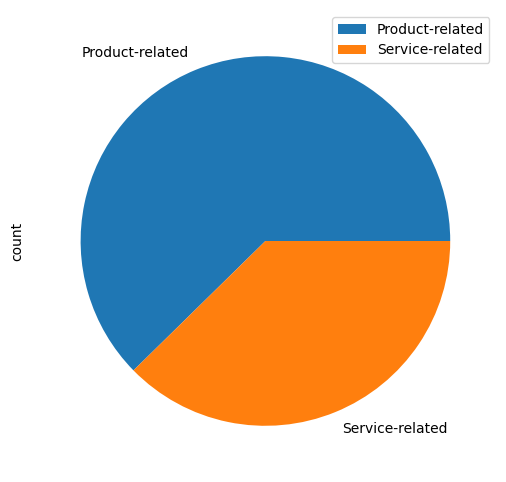

In [373]:
review_cluster_df = cluster_df.groupby(['cluster']).count()
pandas_df = review_cluster_df.toPandas()
pandas_df = pandas_df.set_index('cluster')
pandas_df.plot.pie(y='count', figsize=(6, 6))

In [374]:
stop = time.time()

In [375]:
stop-start

145.9166853427887

## Scalability evaluation - Program execution time

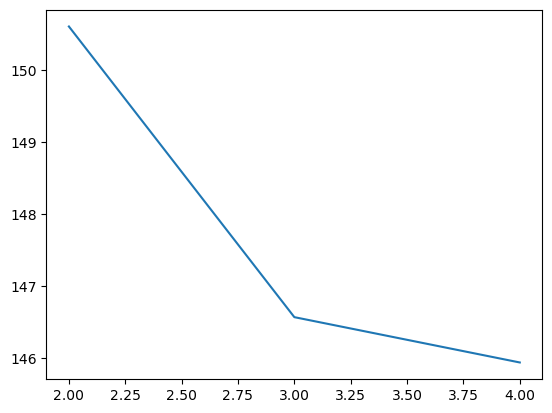

In [377]:
no_of_clusters = [2, 3, 4]
times_recorded = [150.61, 146.57, 145.94]
plt.plot(no_of_clusters, times_recorded)